In [1]:
from sklearn.model_selection import train_test_split,RepeatedKFold
from fancyimpute import MICE # imputation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve,cross_val_score,GridSearchCV
from sklearn.metrics import make_scorer
from jfunc import directory
import warnings


warnings.filterwarnings('ignore')
    
url = 'https://github.com/GinoWoz1/AdvancedHousePrices/raw/master/'
    
df_train = pd.read_csv(url + 'train.csv')
df_test = pd.read_csv(url +'test.csv')
df_train.columns.to_series().groupby(df_train.dtypes).groups

C:\Users\jjonus\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


{dtype('int64'): Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 

In [2]:

# Split data set into test and train
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 80)


In [3]:
# see missing data

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)


,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


In [4]:
# fill in missing data

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['PoolQC'] = all_data['PoolQC'].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["TotalSF"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]

#fill in missing data for garage, basement and mason area

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ( 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('BsmtHalfBath', 'BsmtFullBath', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1','BsmtFinSF2'):
    all_data[col] = all_data[col].fillna(0)


all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data["GarageYrBlt"] = all_data.groupby("Neighborhood")["GarageYrBlt"].transform( lambda x: x.fillna(x.mean()))

# fill in MSzoning values based on knowlege of data
    
all_data.loc[2216,'MSZoning'] = 'RM'
all_data.loc[2904,'MSZoning'] = 'RM'
all_data.loc[1915,'MSZoning'] = 'RM'
all_data.loc[2250,'MSZoning'] = 'RM'
all_data.loc[1915,'Utilities'] = 'AllPub'
all_data.loc[1945,'Utilities'] = 'AllPub'
all_data.loc[2473,'Functional'] = 'Typ'
all_data.loc[2216,'Functional'] = 'Typ'
all_data.loc[2489,'SaleType'] = 'WD'
all_data.loc[2151,'Exterior1st'] = 'Plywood'
all_data.loc[2151,'Exterior2nd'] = 'Plywood'
all_data.loc[1379,'Electrical'] = 'SBrkr'



In [5]:
# analyze which neighborhoods have null data
all_data[pd.isna(all_data['LotFrontage'])].groupby("Neighborhood").size().sort_values(ascending = False)



Neighborhood
NAmes      68
Gilbert    54
Sawyer     53
CollgCr    47
NWAmes     46
ClearCr    24
Mitchel    24
Somerst    20
Crawfor    20
SawyerW    19
NoRidge    17
Edwards    16
Timber     15
BrkSide    13
OldTown    10
Veenker     8
Blmngtn     8
IDOTRR      6
StoneBr     5
MeadowV     4
SWISU       4
NridgHt     3
NPkVill     2
dtype: int64

In [6]:
# feature engineering - conduct encoding of variables to match natural order

all_data['HalfBathTransformed'] = all_data['HalfBath'] * 0.5
all_data['HalfBathBsmtTransformed'] = all_data['BsmtHalfBath'] * 0.5
all_data['Baths'] = all_data['FullBath'] + all_data['HalfBathTransformed'] + all_data['HalfBathBsmtTransformed']  + all_data['BsmtFullBath']


#Excellent, Good, Typical, Fair, Poor, None: Convert to 0-5 scale

cols_ExGd = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

dict_ExGd = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

for col in cols_ExGd:
    all_data[col].replace(dict_ExGd, inplace=True)

all_data.loc[1555,'KitchenQual'] = 3

In [7]:
# feature engineering - grouping like variabels


def neigh(row):
    if row['Neighborhood'] == 'Blmngtn':
        return 'BNS'
    elif row['Neighborhood'] =='Gilbert':
        return 'BNS'
    elif row['Neighborhood'] =='NWAmes':
        return 'BNS' 
    elif row['Neighborhood'] =='SawyerW':
        return 'BNS'
    elif row['Neighborhood']=='Blueste':
        return 'BlueSwis'
    elif row['Neighborhood']=='Mitchel':
        return 'BlueSwis' 
    elif row['Neighborhood'] =='NAmes':
        return 'BlueSwis' 
    elif row['Neighborhood'] =='NPkVill':
        return 'BlueSwis' 
    elif row['Neighborhood'] =='Sawyer':
        return 'BlueSwis' 
    elif row['Neighborhood']=='SWISU':
        return 'BlueSwis'
    elif row['Neighborhood']=='BrDale':
        return 'BrMeadow' 
    elif row['Neighborhood'] =='IDOTRR':
        return 'BrMeadow' 
    elif row['Neighborhood'] =='MeadowV':
        return 'BrMeadow' 
    elif row['Neighborhood'] =='BrkSide':
        return 'BEO' 
    elif row['Neighborhood']=='Edwards':
        return 'BEO'
    elif row['Neighborhood']=='OldTown':
        return 'BEO'
    elif row['Neighborhood'] =='NoRidge':
        return 'NNS' 
    elif row['Neighborhood'] =='NridgHt':
        return 'NNS' 
    elif row['Neighborhood'] =='StoneBr':
        return 'NNS' 
    elif row['Neighborhood']=='Somerst':
        return 'STV'
    elif row['Neighborhood']=='Timber':
        return 'STV' 
    elif row['Neighborhood']=='Veenker':
        return 'STV'
    elif row['Neighborhood']=='CollgCr':
        return 'C3'
    elif row['Neighborhood']=='Crawfor':
        return 'C3' 
    elif row['Neighborhood']=='ClearCr':
        return 'C3'
    else:
        return row['Neighborhood']
 
def bldg_type(row):
    if row['BldgType'] == '1Fam':
        return '1Fam'
    else:
        return 'BldgGroup'

def sub_class(row):
    if row['MSSubClass'] == '60':
        return '60'
    elif row['MSSubClass']=='120':
        return '120'
    elif row['MSSubClass']=='160':
        return 'Group1'
    elif row['MSSubClass']=='190':
        return 'Group1'
    elif row['MSSubClass']=='40':
        return 'Group1'
    elif row['MSSubClass']=='50':
        return 'Group1'
    elif row['MSSubClass']=='70':
        return 'Group1'
    elif row['MSSubClass']=='85':
        return 'Group1'
    elif row['MSSubClass']=='90':
        return 'Group1'
    elif row['MSSubClass']=='180':
        return 'Group2'
    elif row['MSSubClass']=='30':
        return 'Group2'
    elif row['MSSubClass']=='45':
        return 'Group2'
    elif row['MSSubClass']=='20':
        return 'Group3'
    elif row['MSSubClass']=='75':
        return 'Group3'
    elif row['MSSubClass']=='80':
        return 'Group3'                
    else:
        return row['MSSubClass']
    
def foundation(row):
    if row['Foundation'] == 'BrkTil':
        return 'Group1'
    elif row['Foundation']=='CBlock':
        return 'Group1'
    elif row['Foundation']=='Stone':
        return 'Group1'
    elif row['Foundation']=='Wood':
        return 'Group1'
    elif row['Foundation']=='PConc':
        return 'PConc'
    elif row['Foundation']=='Slab':
        return 'Slab'
    else:
        return row['Foundation']

def sale_type(row):
    if row['SaleType'] == 'COD':
        return 'Group1'
    elif row['SaleType']=='ConLD':
        return 'Group1'
    elif row['SaleType']=='ConLw':
        return 'Group1'
    elif row['SaleType']=='Oth':
        return 'Group1'
    elif row['SaleType']=='WD':
        return 'Group1'
    elif row['SaleType']=='Con':
        return 'Group2'
    elif row['SaleType']=='ConLI':
        return 'Group2'
    elif row['SaleType']=='CWD':
        return 'Group2'
    elif row['SaleType']=='New':
        return 'Group2'  
    else:
        return row['SaleType']
    
def exterior_1st(row):
    if row['Exterior1st'] == 'AsbShng':
        return 'Group1'
    elif row['Exterior1st']=='AsphShn':
        return 'Group1'
    elif row['Exterior1st']=='BrkComm':
        return 'Group1'
    elif row['Exterior1st']=='CBlock':
        return 'Group1'
    elif row['Exterior1st']=='BrkFace':
        return 'Group2'
    elif row['Exterior1st']=='CemntBd':
        return 'Group2'
    elif row['Exterior1st']=='ImStucc':
        return 'Group2'
    elif row['Exterior1st']=='Stone':
        return 'Group2'
    elif row['Exterior1st']=='VinylSd':
        return 'Group2'  
    elif row['Exterior1st']=='HdBoard':
        return 'Group3'
    elif row['Exterior1st']=='MetalSd':
        return 'Group4'
    elif row['Exterior1st']=='Stucco':
        return 'Group4'
    elif row['Exterior1st']=='Wd Sdng':
        return 'Group4'
    elif row['Exterior1st']=='WdShing':
        return 'Group4'
    elif row['Exterior1st']=='Plywood':
        return 'Group5'  
    else:
        return row['Exterior1st']
    
def masvnr_type(row):
    if row['MasVnrType'] == 'BrkCmn':
        return 'Group1'
    elif row['MasVnrType']=='None':
        return 'Group1'
    elif row['MasVnrType']=='BrkFace':
        return 'Group2'
    elif row['MasVnrType']=='NA':
        return 'Group3'
    elif row['MasVnrType']=='Stone':
        return 'Group3'
    else:
        return row['MasVnrType']
    
def roof_style(row):
    if row['RoofStyle'] == 'Flat':
        return 'Group1'
    elif row['RoofStyle']=='Hip':
        return 'Group1'
    elif row['RoofStyle']=='Mansard':
        return 'Group1'
    elif row['RoofStyle']=='Shed':
        return 'Group1'
    elif row['RoofStyle']=='Gable':
        return 'Group2'
    elif row['RoofStyle']=='Gambrel':
        return 'Group2'
    else:
        return row['RoofStyle']
    
def mszoning(row):
    if row['MSZoning'] == 'C (all)':
        return 'Group1'
    elif row['MSZoning']=='RH':
        return 'Group1'
    elif row['MSZoning']=='RM':
        return 'Group1'
    elif row['MSZoning']=='FV':
        return 'Group2'
    elif row['MSZoning']=='RL':
        return 'Group2'
    else:
        return row['MSZoning']

def land_contour(row):
    if row['LandContour'] == 'Bnk':
        return 'Group1'
    elif row['LandContour']=='HLS':
        return 'Group2'
    elif row['LandContour']=='Low':
        return 'Group2'
    elif row['LandContour']=='Lvl':
        return 'Group3'
    else:
        return row['LandContour']
             
def exposure(row):
    if row['BsmtExposure'] == 'Av':
        return 'Group1'
    elif row['BsmtExposure']=='Mn':
        return 'Group1'
    elif row['BsmtExposure']=='Gd':
        return 'Group2'
    elif row['BsmtExposure']=='NA':
        return 'Group3'
    elif row['BsmtExposure']=='No':
        return 'Group4'
    else:
        return row['BsmtExposure']

def electrical(row):
    if row['Electrical'] == 'FuseA':
        return 'Group1'
    elif row['Electrical']=='FuseF':
        return 'Group1'
    elif row['Electrical']=='FuseP':
        return 'Group1'
    elif row['Electrical']=='Mix':
        return 'Group1'
    elif row['Electrical']=='NA':
        return 'Group1'
    elif row['Electrical']=='SBrkr':
        return 'Group2'
    else:
        return row['Electrical']

def lot_shape(row):
    if row['LotShape'] == 'IR1':
        return 'Group1'
    elif row['LotShape']=='IR2':
        return 'Group2'
    elif row['LotShape']=='IR3':
        return 'Group2'
    elif row['LotShape']=='Reg':
        return 'Group3'
    else:
        return row['LotShape']   

def sale_condition(row):
    if row['SaleCondition'] == 'Abnorml':
        return 'Group1'
    elif row['SaleCondition']=='AdjLand':
        return 'Group1'
    elif row['SaleCondition']=='Alloca':
        return 'Group1'
    elif row['SaleCondition']=='Family':
        return 'Group1'
    elif row['SaleCondition']=='Normal':
        return 'Group2'
    elif row['SaleCondition']=='Partial':
        return 'Group2'
    else:
        return row['SaleCondition']   
    
    
all_data['SaleTypeGroup'] = all_data.apply(sale_type,axis=1)
all_data['FoundationGroup'] = all_data.apply(foundation,axis=1) 
all_data['MSSubClassGroup'] = all_data.apply(sub_class,axis=1) 
all_data['BldgGroup'] = all_data.apply(bldg_type,axis=1)
all_data['NeighGroup'] = all_data.apply(neigh,axis=1)  
all_data['Ext1stGrp'] = all_data.apply(exterior_1st,axis=1)
all_data['MasVnrGroup'] = all_data.apply(masvnr_type,axis=1)
all_data['RoofstyleGroup'] = all_data.apply(roof_style,axis=1)
all_data['MSZoningGroup'] = all_data.apply(mszoning,axis=1)
all_data['LandContourGroup'] = all_data.apply(land_contour,axis=1)
all_data['ExposureGroup'] = all_data.apply(exposure,axis=1)
all_data['ElectricalGroup'] = all_data.apply(electrical,axis=1)
all_data['LotShapeGroup'] = all_data.apply(lot_shape,axis=1)
all_data['SaleConditionGroup'] = all_data.apply(sale_condition,axis=1)

In [8]:
all_data['After91'] = np.where(all_data['YearBuilt'] > 1991,1,0)  
all_data['YearBuiltRev'] = all_data['YearBuilt'] - 1875

# Exter and KitchenQual Combined

all_data['KitchenExterQual'] = all_data['KitchenQual'] + all_data['ExterQual']

dummy_cols = ['2ndFlrSF',
              'MiscVal','ScreenPorch','WoodDeckSF','OpenPorchSF',
              'EnclosedPorch','MasVnrArea','GarageArea','Fireplaces','TotalBsmtSF']

for col in dummy_cols:
    all_data['Has'+col] = (all_data[col]>0).astype(int)
    
# column for MasVnrStone    
all_data['HasVnrStone'] = np.where(all_data['MasVnrType'] == 'Stone',1,0)

#columns for HeatingQC
all_data['HeatingEx'] = np.where(all_data['HeatingQC'] == 5,1,0)

# duplex
all_data['IsDuplex'] = np.where(all_data['BldgType'] == "Duplex",1,0)

# foundation is concrete
all_data['HasPconc'] = np.where(all_data['Foundation'] == "PConc",1,0)


In [10]:
# imputation
numeric_data_train = train.select_dtypes(include = ['float64','int64'])
solver=MICE()
Imputed_dataframe_train= pd.DataFrame(data = solver.complete(numeric_data_train),columns = numeric_data_train.columns,index = numeric_data_train.index)
numeric_data_test = test.select_dtypes(include = ['float64','int64'])
solver=MICE()
Imputed_dataframe_test= pd.DataFrame(data = solver.complete(numeric_data_test),columns = numeric_data_test.columns,index = numeric_data_test.index)

train['LotFrontage'] = Imputed_dataframe_train['LotFrontage']
test['LotFrontage'] = Imputed_dataframe_test['LotFrontage']


[MICE] Completing matrix with shape (1460, 52)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.254
[MICE] Starting imputation round 3/110, elapsed time 0.256
[MICE] Starting imputation round 4/110, elapsed time 0.258
[MICE] Starting imputation round 5/110, elapsed time 0.260
[MICE] Starting imputation round 6/110, elapsed time 0.263
[MICE] Starting imputation round 7/110, elapsed time 0.265
[MICE] Starting imputation round 8/110, elapsed time 0.266
[MICE] Starting imputation round 9/110, elapsed time 0.268
[MICE] Starting imputation round 10/110, elapsed time 0.270
[MICE] Starting imputation round 11/110, elapsed time 0.272
[MICE] Starting imputation round 12/110, elapsed time 0.275
[MICE] Starting imputation round 13/110, elapsed time 0.277
[MICE] Starting imputation round 14/110, elapsed time 0.279
[MICE] Starting imputation round 15/110, elapsed time 0.281
[MICE] Starting imputation round 16/110, elapsed time 0.283
[M

[MICE] Starting imputation round 73/110, elapsed time 0.188
[MICE] Starting imputation round 74/110, elapsed time 0.192
[MICE] Starting imputation round 75/110, elapsed time 0.196
[MICE] Starting imputation round 76/110, elapsed time 0.199
[MICE] Starting imputation round 77/110, elapsed time 0.203
[MICE] Starting imputation round 78/110, elapsed time 0.207
[MICE] Starting imputation round 79/110, elapsed time 0.211
[MICE] Starting imputation round 80/110, elapsed time 0.214
[MICE] Starting imputation round 81/110, elapsed time 0.217
[MICE] Starting imputation round 82/110, elapsed time 0.220
[MICE] Starting imputation round 83/110, elapsed time 0.224
[MICE] Starting imputation round 84/110, elapsed time 0.227
[MICE] Starting imputation round 85/110, elapsed time 0.231
[MICE] Starting imputation round 86/110, elapsed time 0.234
[MICE] Starting imputation round 87/110, elapsed time 0.238
[MICE] Starting imputation round 88/110, elapsed time 0.241
[MICE] Starting imputation round 89/110,

In [12]:
# gather columns with highest mutual informatoin- need to take outside to excel and commented out here
"""
column_list = X_train.columns.tolist()

new_dict = {}

for c in column_list:
    Xmi_train = X_train[[c]]
    mi = mutual_info_regression(Xmi_train,y_train)
    new_dict[c] = sum(mi)
"""

'\ncolumn_list = X_train.columns.tolist()\n\nnew_dict = {}\n\nfor c in column_list:\n    Xmi_train = X_train[[c]]\n    mi = mutual_info_regression(Xmi_train,y_train)\n    new_dict[c] = sum(mi)\n'

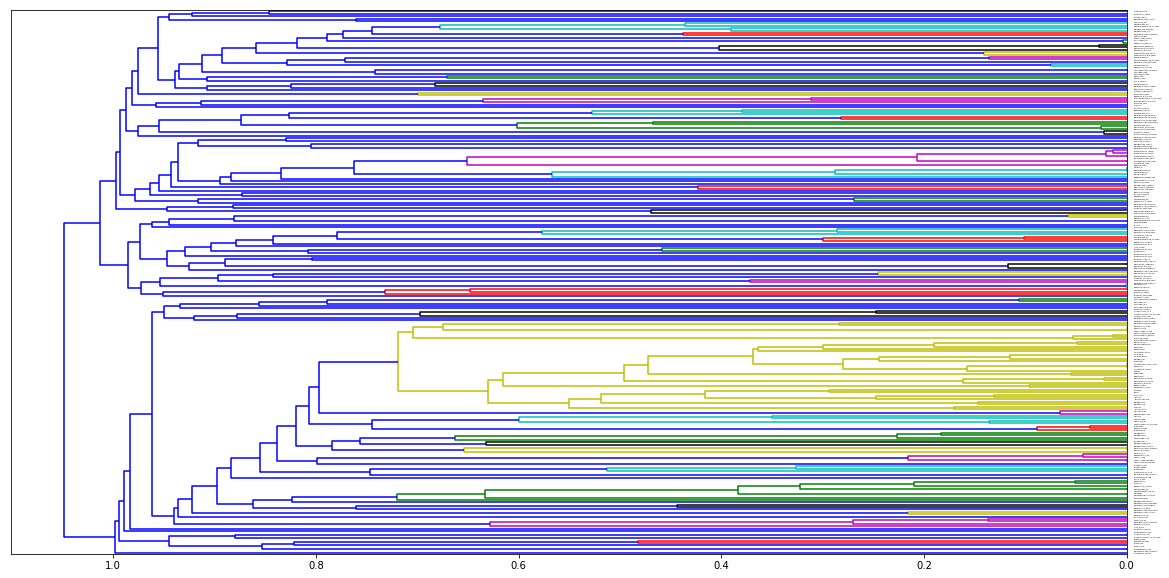

In [12]:
# select columns common across both sets + mutual information above 0

X_train = X_train[['TotalSF',	'OverallQual',	'KitchenExterQual',	'GrLivArea',	'TotalBsmtSF',	'GarageArea',	'GarageCars',	'Baths',	'ExterQual',	'KitchenQual',	'BsmtQual',	'GarageYrBlt',	'FullBath',	'YearBuiltRev',	'YearBuilt',	'1stFlrSF',	'After91',	'LotFrontage',	'YearRemodAdd',	'FireplaceQu',	'HasPconc',	'HasFireplaces',	'FoundationGroup_PConc',	'TotRmsAbvGrd',	'Fireplaces',	'HeatingQC',	'Foundation_PConc',	'NeighGroup_NNS',	'BsmtFinSF1',	'GarageFinish_Unf',	'HasOpenPorchSF',	'HeatingEx',	'NeighGroup_BlueSwis',	'MSSubClassGroup_60',	'BsmtUnfSF',	'GarageType_Attchd',	'MSSubClass_60',	'OverallCond',	'2ndFlrSF',	'Foundation_CBlock',	'MSZoningGroup_Group2',	'GarageType_Detchd',	'BsmtFinType1_GLQ',	'Exterior2nd_VinylSd',	'Ext1stGrp_Group2',	'HalfBathTransformed',	'HalfBath',	'MasVnrArea',	'LotArea',	'SaleType_New',	'SaleCondition_Partial',	'LotShape_Reg',	'LotShapeGroup_Group3',	'MSSubClassGroup_Group2',	'GarageFinish_RFn',	'SaleTypeGroup_Group2',	'BedroomAbvGr',	'Ext1stGrp_Group4',	'NeighGroup_BNS',	'MSZoning_RM',	'Neighborhood_NAmes',	'HasWoodDeckSF',	'Exterior1st_VinylSd',	'NeighGroup_STV',	'MasVnrType_None',	'MasVnrType_Stone',	'NeighGroup_C3',	'OpenPorchSF',	'GarageFinish_None',	'HasVnrStone',	'Neighborhood_NridgHt',	'HasMasVnrArea',	'Electrical_SBrkr',	'MSSubClass_30',	'Neighborhood_Somerst',	'MasVnrGroup_Group3',	'GarageCond',	'Neighborhood_NoRidge',	'Exterior2nd_Wd Sdng',	'MSZoning_RL',	'WoodDeckSF',	'SaleType_WD',	'GarageType_None',	'NeighGroup_BrMeadow',	'HasGarageArea',	'MasVnrGroup_Group2',	'BsmtCond',	'Neighborhood_OldTown',	'MSSubClassGroup_Group1',	'Neighborhood_CollgCr',	'Neighborhood_Gilbert',	'BsmtExposure_Gd',	'MasVnrType_BrkFace',	'Fence_None',	'GarageQual',	'CentralAir_Y',	'Exterior1st_Wd Sdng',	'HouseStyle_2Story',	'BldgType_Duplex',	'HasEnclosedPorch',	'Neighborhood_IDOTRR',	'BsmtFinType2_None',	'IsDuplex',	'MSZoning_FV',	'ElectricalGroup_Group2',	'BsmtFullBath',	'EnclosedPorch',	'PavedDrive_Y',	'HasScreenPorch',	'ExposureGroup_Group2',	'Neighborhood_BrkSide',	'BsmtFinType1_None',	'LotConfig_CulDSac',	'HasTotalBsmtSF',	'ExposureGroup_Group4',	'Neighborhood_NPkVill',	'Alley_None',	'Fence_MnPrv',	'ExposureGroup_None',	'RoofstyleGroup_Group2',	'GarageType_BuiltIn',	'MSSubClass_50',	'Electrical_FuseF',	'Has2ndFlrSF',	'BldgGroup_BldgGroup',	'BsmtExposure_None',	'Neighborhood_BrDale',	'Exterior2nd_MetalSd',	'BsmtExposure_No',	'MSSubClass_160',	'Ext1stGrp_Group3',	'Neighborhood_Edwards',	'Exterior1st_MetalSd',	'SaleCondition_Normal',	'HouseStyle_SLvl',	'Neighborhood_Sawyer',	'SaleType_ConLD',	'MSSubClass_80',	'Foundation_Wood',	'BsmtFinType1_Rec',	'LandContourGroup_Group2',	'ScreenPorch',	'Ext1stGrp_Group5',	'YrSold',	'Neighborhood_StoneBr',	'Exterior2nd_Plywood',	'GarageType_CarPort',	'MSSubClass_90',	'BsmtHalfBath',	'LandContourGroup_Group3',	'Exterior2nd_CmentBd',	'MSSubClassGroup_Group3',	'Neighborhood_Crawfor',	'Neighborhood_NWAmes',	'LotConfig_Inside',	'Functional_Typ',	'Neighborhood_SawyerW',	'Exterior2nd_HdBoard',	'Foundation_Slab',	'BldgType_Twnhs',	'KitchenAbvGr',	'MSSubClass_180',	'ExterCond',	'LandContour_Low',	'HouseStyle_SFoyer',	'HouseStyle_1Story',	'Exterior1st_HdBoard',	'FoundationGroup_Slab',	'MSSubClass_85',	'Neighborhood_Mitchel',	'Exterior2nd_Stucco',	'PoolQC',	'HouseStyle_1.5Unf',	'MSSubClass_20',	'Alley_Pave',	'RoofStyle_Shed',	'BsmtFinType1_BLQ',	'SaleCondition_Alloca',	'Exterior2nd_Wd Shng',	'BsmtExposure_Mn',	'Electrical_FuseP',	'Heating_Wall',	'MSSubClass_45',	'Neighborhood_Blueste',	'Neighborhood_Timber',	'Functional_Min2',	'HasMiscVal',	'RoofStyle_Hip',	'HalfBathBsmtTransformed',	'RoofStyle_Gable',	'BldgType_2fmCon',	'Exterior2nd_Brk Cmn',	'LandContour_HLS',	'LotShape_IR3',	'LotShape_IR2',	'Exterior1st_AsphShn',	'Exterior2nd_AsphShn',	'PavedDrive_P',	'RoofMatl_WdShake',	'LotShapeGroup_Group2',	'RoofMatl_WdShngl',	'Street_Pave',	'Condition1_RRAe',	'Condition2_Feedr',	'SaleType_CWD',	'SaleConditionGroup_Group2',	'Functional_Mod',	'BsmtFinType2_BLQ',	'RoofMatl_Tar&Grv',	'LandContour_Lvl',	'MSZoning_RH',	'HouseStyle_2.5Unf',	'Neighborhood_Veenker',	'MSSubClass_70',	'Exterior1st_CemntBd',	'Condition1_PosA',	'Condition1_PosN',	'Neighborhood_SWISU',	'Condition2_Norm',	'BsmtFinSF2',	'Exterior1st_WdShing',	'Neighborhood_MeadowV',	'MSSubClass_40',	'Condition2_PosA',	'BsmtFinType2_Rec',	'LowQualFinSF',	'RoofStyle_Gambrel']]
X_test = X_test[['TotalSF',	'OverallQual',	'KitchenExterQual',	'GrLivArea',	'TotalBsmtSF',	'GarageArea',	'GarageCars',	'Baths',	'ExterQual',	'KitchenQual',	'BsmtQual',	'GarageYrBlt',	'FullBath',	'YearBuiltRev',	'YearBuilt',	'1stFlrSF',	'After91',	'LotFrontage',	'YearRemodAdd',	'FireplaceQu',	'HasPconc',	'HasFireplaces',	'FoundationGroup_PConc',	'TotRmsAbvGrd',	'Fireplaces',	'HeatingQC',	'Foundation_PConc',	'NeighGroup_NNS',	'BsmtFinSF1',	'GarageFinish_Unf',	'HasOpenPorchSF',	'HeatingEx',	'NeighGroup_BlueSwis',	'MSSubClassGroup_60',	'BsmtUnfSF',	'GarageType_Attchd',	'MSSubClass_60',	'OverallCond',	'2ndFlrSF',	'Foundation_CBlock',	'MSZoningGroup_Group2',	'GarageType_Detchd',	'BsmtFinType1_GLQ',	'Exterior2nd_VinylSd',	'Ext1stGrp_Group2',	'HalfBathTransformed',	'HalfBath',	'MasVnrArea',	'LotArea',	'SaleType_New',	'SaleCondition_Partial',	'LotShape_Reg',	'LotShapeGroup_Group3',	'MSSubClassGroup_Group2',	'GarageFinish_RFn',	'SaleTypeGroup_Group2',	'BedroomAbvGr',	'Ext1stGrp_Group4',	'NeighGroup_BNS',	'MSZoning_RM',	'Neighborhood_NAmes',	'HasWoodDeckSF',	'Exterior1st_VinylSd',	'NeighGroup_STV',	'MasVnrType_None',	'MasVnrType_Stone',	'NeighGroup_C3',	'OpenPorchSF',	'GarageFinish_None',	'HasVnrStone',	'Neighborhood_NridgHt',	'HasMasVnrArea',	'Electrical_SBrkr',	'MSSubClass_30',	'Neighborhood_Somerst',	'MasVnrGroup_Group3',	'GarageCond',	'Neighborhood_NoRidge',	'Exterior2nd_Wd Sdng',	'MSZoning_RL',	'WoodDeckSF',	'SaleType_WD',	'GarageType_None',	'NeighGroup_BrMeadow',	'HasGarageArea',	'MasVnrGroup_Group2',	'BsmtCond',	'Neighborhood_OldTown',	'MSSubClassGroup_Group1',	'Neighborhood_CollgCr',	'Neighborhood_Gilbert',	'BsmtExposure_Gd',	'MasVnrType_BrkFace',	'Fence_None',	'GarageQual',	'CentralAir_Y',	'Exterior1st_Wd Sdng',	'HouseStyle_2Story',	'BldgType_Duplex',	'HasEnclosedPorch',	'Neighborhood_IDOTRR',	'BsmtFinType2_None',	'IsDuplex',	'MSZoning_FV',	'ElectricalGroup_Group2',	'BsmtFullBath',	'EnclosedPorch',	'PavedDrive_Y',	'HasScreenPorch',	'ExposureGroup_Group2',	'Neighborhood_BrkSide',	'BsmtFinType1_None',	'LotConfig_CulDSac',	'HasTotalBsmtSF',	'ExposureGroup_Group4',	'Neighborhood_NPkVill',	'Alley_None',	'Fence_MnPrv',	'ExposureGroup_None',	'RoofstyleGroup_Group2',	'GarageType_BuiltIn',	'MSSubClass_50',	'Electrical_FuseF',	'Has2ndFlrSF',	'BldgGroup_BldgGroup',	'BsmtExposure_None',	'Neighborhood_BrDale',	'Exterior2nd_MetalSd',	'BsmtExposure_No',	'MSSubClass_160',	'Ext1stGrp_Group3',	'Neighborhood_Edwards',	'Exterior1st_MetalSd',	'SaleCondition_Normal',	'HouseStyle_SLvl',	'Neighborhood_Sawyer',	'SaleType_ConLD',	'MSSubClass_80',	'Foundation_Wood',	'BsmtFinType1_Rec',	'LandContourGroup_Group2',	'ScreenPorch',	'Ext1stGrp_Group5',	'YrSold',	'Neighborhood_StoneBr',	'Exterior2nd_Plywood',	'GarageType_CarPort',	'MSSubClass_90',	'BsmtHalfBath',	'LandContourGroup_Group3',	'Exterior2nd_CmentBd',	'MSSubClassGroup_Group3',	'Neighborhood_Crawfor',	'Neighborhood_NWAmes',	'LotConfig_Inside',	'Functional_Typ',	'Neighborhood_SawyerW',	'Exterior2nd_HdBoard',	'Foundation_Slab',	'BldgType_Twnhs',	'KitchenAbvGr',	'MSSubClass_180',	'ExterCond',	'LandContour_Low',	'HouseStyle_SFoyer',	'HouseStyle_1Story',	'Exterior1st_HdBoard',	'FoundationGroup_Slab',	'MSSubClass_85',	'Neighborhood_Mitchel',	'Exterior2nd_Stucco',	'PoolQC',	'HouseStyle_1.5Unf',	'MSSubClass_20',	'Alley_Pave',	'RoofStyle_Shed',	'BsmtFinType1_BLQ',	'SaleCondition_Alloca',	'Exterior2nd_Wd Shng',	'BsmtExposure_Mn',	'Electrical_FuseP',	'Heating_Wall',	'MSSubClass_45',	'Neighborhood_Blueste',	'Neighborhood_Timber',	'Functional_Min2',	'HasMiscVal',	'RoofStyle_Hip',	'HalfBathBsmtTransformed',	'RoofStyle_Gable',	'BldgType_2fmCon',	'Exterior2nd_Brk Cmn',	'LandContour_HLS',	'LotShape_IR3',	'LotShape_IR2',	'Exterior1st_AsphShn',	'Exterior2nd_AsphShn',	'PavedDrive_P',	'RoofMatl_WdShake',	'LotShapeGroup_Group2',	'RoofMatl_WdShngl',	'Street_Pave',	'Condition1_RRAe',	'Condition2_Feedr',	'SaleType_CWD',	'SaleConditionGroup_Group2',	'Functional_Mod',	'BsmtFinType2_BLQ',	'RoofMatl_Tar&Grv',	'LandContour_Lvl',	'MSZoning_RH',	'HouseStyle_2.5Unf',	'Neighborhood_Veenker',	'MSSubClass_70',	'Exterior1st_CemntBd',	'Condition1_PosA',	'Condition1_PosN',	'Neighborhood_SWISU',	'Condition2_Norm',	'BsmtFinSF2',	'Exterior1st_WdShing',	'Neighborhood_MeadowV',	'MSSubClass_40',	'Condition2_PosA',	'BsmtFinType2_Rec',	'LowQualFinSF',	'RoofStyle_Gambrel']]

 # look at highly correlated variables and remove

from jfunc import pear_corr_highres

pear_corr_highres(X_train)
remove = ['BsmtExposure_None','BsmtFinType1_None','BsmtExposure_No','Exterior2nd_MetalSd','SaleType_New','BsmtFinType2_None','EnclosedPorch','LotShape_Reg','HalfBathBsmtTransformed','BsmtHalfBath','HalfBath','HalfBathTransformed','MSSubClass_60','LandContour_Lvl','Exterior1st_HdBoard','RoofStyle_Gable','Exterior2nd_VinylSd','Foundation_Slab','GarageType_None','Exterior2nd_CmentBd','IsDuplex','BldgType_Duplex','ScreenPorch','Foundation_PConc','YearBuiltRev','HasVnrStone','MasVnrType_Stone','HasPconc','Exterior2nd_VinylSd','ElectricalGroup_Group2','MasVnrType_BrkFace','BsmtExposure_Gd']

def drop_cols(dataframe,columns_remove):
    cols =list(dataframe.columns.values)
    for col in columns_remove:
        for c in cols:
            if c == col:
                cols.remove(c)
            elif c != col:
                continue
    dataframe = dataframe[cols]
    return dataframe

X_train = drop_cols(X_train,remove)
X_test = drop_cols(X_test,remove)

In [13]:
# define scoring functions for training models

def rmsle(y_true, y_pred): 
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

def rmsle_cv(y_true, y_pred) : 
    assert len(y_true) == len(y_pred)
    if not (y_true >= 0).all() and not (y_pred >= 0).all():
        raise ValueError("Mean Squared Logarithmic Error cannot be used when "
                         "targets contain negative values.")
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_true))**2))

rmsle_cv = make_scorer(rmsle_cv,greater_is_better=False)   

In [15]:
# spot check models
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

rkfold = RepeatedKFold(n_splits=5, n_repeats=5)

In [17]:
# create a dict of standard models to evaluate {name:object}
def get_models(models=dict()):
	# linear models
	models['lr'] = LinearRegression()
	alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['lasso-'+str(a)] = Lasso(alpha=a)
	for a in alpha:
		models['ridge-'+str(a)] = Ridge(alpha=a)
	for a1 in alpha:
		for a2 in alpha:
			name = 'en-' + str(a1) + '-' + str(a2)
			models[name] = ElasticNet(a1, a2)
	models['huber'] = HuberRegressor()
	models['lars'] = Lars()
	models['llars'] = LassoLars()
	models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
	models['ranscac'] = RANSACRegressor()
	models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
	models['theil'] = TheilSenRegressor()
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsRegressor(n_neighbors=k)
	models['cart'] = DecisionTreeRegressor()
	models['extra'] = ExtraTreeRegressor()
	models['svml'] = SVR(kernel='linear')
	models['svmp'] = SVR(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVR(C=c)
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
	models['bag'] = BaggingRegressor(n_estimators=n_trees)
	models['rf'] = RandomForestRegressor(n_estimators=n_trees)
	models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
	models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=rkfold, n_jobs=1)
	return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model,metric)
	except:
		scores = None
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=20):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')
 

In [18]:
# load dataset
# get model list
models = get_models()


Defined 190 models


In [19]:
# evaluate models
results = evaluate_models(X_train, y_train, models, metric=rmsle_cv)
# summarize results


>lr: -0.678 (+/-0.756)
>lasso-0.0: -0.186 (+/-0.027)
>lasso-0.1: -0.204 (+/-0.051)
>lasso-0.2: -0.199 (+/-0.060)
>lasso-0.3: -0.197 (+/-0.036)
>lasso-0.4: -0.201 (+/-0.031)
>lasso-0.5: -0.190 (+/-0.037)
>lasso-0.6: -0.189 (+/-0.029)
>lasso-0.7: -0.205 (+/-0.065)
>lasso-0.8: -0.191 (+/-0.031)
>lasso-0.9: -0.190 (+/-0.027)
>lasso-1.0: -0.188 (+/-0.023)
>ridge-0.0: -1.109 (+/-1.101)
>ridge-0.1: -0.188 (+/-0.037)
>ridge-0.2: -0.184 (+/-0.024)
>ridge-0.3: -0.192 (+/-0.034)
>ridge-0.4: -0.194 (+/-0.037)
>ridge-0.5: -0.181 (+/-0.029)
>ridge-0.6: -0.179 (+/-0.023)
>ridge-0.7: -0.176 (+/-0.023)
>ridge-0.8: -0.175 (+/-0.018)
>ridge-0.9: -0.173 (+/-0.020)
>ridge-1.0: -0.179 (+/-0.032)
>en-0.0-0.0: -0.183 (+/-0.027)
>en-0.0-0.1: -0.186 (+/-0.025)
>en-0.0-0.2: -0.189 (+/-0.022)
>en-0.0-0.3: -0.195 (+/-0.050)
>en-0.0-0.4: -0.184 (+/-0.021)
>en-0.0-0.5: -0.197 (+/-0.041)
>en-0.0-0.6: -0.189 (+/-0.038)
>en-0.0-0.7: -0.196 (+/-0.035)
>en-0.0-0.8: -0.200 (+/-0.042)
>en-0.0-0.9: -0.184 (+/-0.018)
>en-0.0


Rank=1, Name=gbm, Score=-0.129 (+/- 0.011)
Rank=2, Name=et, Score=-0.135 (+/- 0.010)
Rank=3, Name=bag, Score=-0.140 (+/- 0.014)
Rank=4, Name=rf, Score=-0.142 (+/- 0.013)
Rank=5, Name=huber, Score=-0.144 (+/- 0.016)
Rank=6, Name=pa, Score=-0.151 (+/- 0.009)
Rank=7, Name=en-0.1-0.8, Score=-0.151 (+/- 0.014)
Rank=8, Name=en-0.3-0.9, Score=-0.151 (+/- 0.011)
Rank=9, Name=en-0.1-0.9, Score=-0.151 (+/- 0.008)
Rank=10, Name=en-0.2-0.9, Score=-0.152 (+/- 0.011)
Rank=11, Name=en-0.1-0.7, Score=-0.153 (+/- 0.010)
Rank=12, Name=en-0.2-0.8, Score=-0.155 (+/- 0.011)
Rank=13, Name=en-0.4-0.9, Score=-0.155 (+/- 0.011)
Rank=14, Name=en-0.1-0.6, Score=-0.156 (+/- 0.012)
Rank=15, Name=en-0.5-0.9, Score=-0.157 (+/- 0.009)
Rank=16, Name=en-0.1-0.5, Score=-0.158 (+/- 0.011)
Rank=17, Name=en-0.3-0.8, Score=-0.158 (+/- 0.014)
Rank=18, Name=sgd, Score=-0.158 (+/- 0.010)
Rank=19, Name=en-0.2-0.7, Score=-0.159 (+/- 0.010)
Rank=20, Name=en-0.1-0.4, Score=-0.159 (+/- 0.008)


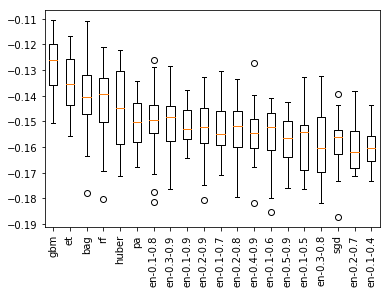

In [44]:
summarize_results(results)

In [16]:
# run tune top models then try selectKBest

hubs = HuberRegressor()
params = ({'hubs__epsilon':np.arange(1.3,1.7,0.05)})

hubs_pipeline = Pipeline([('std',StandardScaler()),
                 ('hubs',hubs)])

gs = GridSearchCV(hubs_pipeline,param_grid=params,cv=rkfold,scoring=rmsle_cv)

gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_estimator_)



-0.15675191193905416
Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('hubs', HuberRegressor(alpha=0.0001, epsilon=1.3, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False))])


In [17]:

gb = GradientBoostingRegressor()

gb_params = ({'loss':['ls','lad','huber','quantile'],
          'learning_rate':np.arange(0.01,0.1,0.05),
          'max_depth':[3,5,7],
          'max_features':[0.4,0.5,0.6]})

gs2 = GridSearchCV(estimator=gb,param_grid=gb_params,cv=rkfold,scoring=rmsle_cv)
gs2.fit(X_train,y_train)
print(gs2.best_score_)
print(gs2.best_estimator_)


-0.1282706881635881
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.060000000000000005, loss='ls', max_depth=5,
             max_features=0.4, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [18]:

rf = RandomForestRegressor(n_estimators=100)

rf_params = ({'max_depth':[3,5,7],
             'max_features':[0.4,0.5,0.6]})

gs3 = GridSearchCV(estimator=rf,param_grid=rf_params,cv=rkfold,scoring=rmsle_cv)
gs3.fit(X_train,y_train)
print(gs3.best_score_)
print(gs3.best_estimator_)



-0.1466073377623652
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [19]:
bag = BaggingRegressor(n_estimators=100)

bag_params = ({'max_features':[0.4,0.5,0.6],
              'bootstrap_features':[False,True]})

gs4= GridSearchCV(estimator=bag,param_grid=bag_params,cv=rkfold,scoring=rmsle_cv)
gs4.fit(X_train,y_train)
print(gs4.best_score_)
print(gs4.best_estimator_)



-0.1381893756447575
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=0.5, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


In [20]:
# test feature selection on these models

from sklearn.feature_selection import SelectKBest,f_regression

k_best = SelectKBest(f_regression)

hubs = HuberRegressor(alpha=0.0001, epsilon=1.3, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

k_params = ({'k_best__k':range(1,len(X_train.columns.tolist()),1)})

hubs_pipeline = Pipeline([('k_best',k_best),
                 ('std',StandardScaler()),
                 ('hubs',hubs)])

gs5 = GridSearchCV(hubs_pipeline,param_grid=k_params,cv=rkfold,scoring=rmsle_cv)

gs5.fit(X_train,y_train)
print(gs5.best_score_)
print(gs5.best_estimator_)


-0.14925182060147035
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=110, score_func=<function f_regression at 0x000000254A58E598>)), ('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('hubs', HuberRegressor(alpha=0.0001, epsilon=1.3, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False))])


In [21]:
# gb

k_best = SelectKBest(f_regression)

gb = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.060000000000000005, loss='ls', max_depth=5,
             max_features=0.4, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

k_params = ({'k_best__k':range(1,len(X_train.columns.tolist()),1)})

gb_pipe = Pipeline([('k_best',k_best),
                   ('gb',gb)])

gs6 = GridSearchCV(gb_pipe,param_grid=k_params,cv=rkfold,scoring=rmsle_cv)
gs6.fit(X_train,y_train)
print(gs6.best_score_)
print(gs6.best_estimator_)



-0.12701212382601323
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=158, score_func=<function f_regression at 0x000000254A58E598>)), ('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.060000000000000005, loss='ls', max_depth=5,
             max_features=0.4, max_leaf_nodes=Non...     subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False))])


In [22]:
# rf

rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

k_params = ({'k_best__k':range(1,len(X_train.columns.tolist()),1)})

rf_pipe = Pipeline([('k_best',k_best),
                   ('rf',rf)])

gs7 = GridSearchCV(rf_pipe,param_grid=k_params,cv=rkfold,scoring=rmsle_cv)
gs7.fit(X_train,y_train)
print(gs7.best_score_)
print(gs7.best_estimator_)



-0.1456316900489914
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=147, score_func=<function f_regression at 0x000000254A58E598>)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])


In [23]:
# bagging

bag = BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=0.4, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

k_params = ({'k_best__k':range(5,len(X_train.columns.tolist()),1)})

bag_pipe = Pipeline([('k_best',k_best),
                    ('bag',bag)])

gs8 = GridSearchCV(bag_pipe,param_grid=k_params,cv=rkfold,scoring=rmsle_cv,error_score=0.0)
gs8.fit(X_train,y_train)
print(gs8.best_score_)
print(gs8.best_estimator_)


-0.13828831622925178
Pipeline(memory=None,
     steps=[('k_best', SelectKBest(k=174, score_func=<function f_regression at 0x000000254A58E598>)), ('bag', BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=0.4, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False))])


In [ ]:
# best model is gradient boosting with 158 variables (instead of 178)

# gb - scores very similar to its 0.127 score on kaggle

k_best = SelectKBest(f_regression)

gb = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.060000000000000005, loss='ls', max_depth=5,
             max_features=0.4, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

k_params = ({'k_best__k':range(1,len(X_train.columns.tolist()),1)})

gb_pipe = Pipeline([('k_best',k_best),
                   ('gb',gb)])

gs6 = GridSearchCV(gb_pipe,param_grid=k_params,cv=rkfold,scoring=rmsle_cv)
gs6.fit(X_train,y_train)
print(gs6.best_score_)
print(gs6.best_estimator_)


